## Setup Libraries

In [17]:
# data manipulation
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# models, feature extraction, metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix

# pipeline
from sklearn.pipeline import make_pipeline

# data preprocessing
import contractions
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

# string
import re
import string

# warning
import warnings
warnings.filterwarnings('ignore')

# set stopwords
stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fahrizain\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\fahrizain\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Load Dataset

In [18]:
train = pd.read_csv('../data/raw/train.csv')
train.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [19]:
test = pd.read_csv('../data/raw/test.csv')
test_labels = pd.read_csv('../data/raw/test_labels.csv')

# merge test data and its labels
test = test.merge(test_labels, how='inner', on='id')
test.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,":If you have a look back at the source, the in...",-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,I don't anonymously edit articles at all.,-1,-1,-1,-1,-1,-1


In [20]:
train.shape, test.shape

((159571, 8), (153164, 8))

In [21]:
train.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [22]:
train[train['toxic'] > 0].head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
12,0005c987bdfc9d4b,Hey... what is it..\n@ | talk .\nWhat is it......,1,0,0,0,0,0
16,0007e25b2121310b,"Bye! \n\nDon't look, come or think of comming ...",1,0,0,0,0,0
42,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1
43,00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,0,1,0,1,0


In [23]:
# merge all toxic labels
def is_toxic(row):    
    return 1 if row.sum() > 1 else -1 if row.sum() < 0 else 0

train['is_toxic'] = train.iloc[:, 2:].apply(is_toxic, axis=1)
train['is_toxic'].value_counts()

0    149706
1      9865
Name: is_toxic, dtype: int64

In [24]:
# apply to test dataset
test['is_toxic'] = test.iloc[:, 2:].apply(is_toxic, axis=1)
test = test[test['is_toxic'] >= 0]
test['is_toxic'].value_counts()

0    59577
1     4401
Name: is_toxic, dtype: int64

In [25]:
# drop test data with label -1
test_toxic = test[['comment_text', 'is_toxic']]
test_toxic.head()

,comment_text,is_toxic
5,Thank you for understanding. I think very high...,0
7,:Dear god this site is horrible.,0
11,"""::: Somebody will invariably try to add Relig...",0
13,""" \n\n It says it right there that it IS a typ...",0
14,""" \n\n == Before adding a new product to the l...",0


In [26]:
# turns into binary label
train_toxic = train[['comment_text', 'is_toxic']]
train_toxic.head()

,comment_text,is_toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


## Exploration

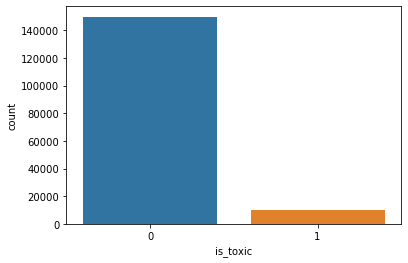

In [27]:
sns.countplot(data=train_toxic, x='is_toxic')

## Text Cleaning
Remove:
- Links
- Punctuation
- Numbers
- White-Spaces
- Non-Ascii
- Emoji

In [38]:
def fix_contractions(text):
    fix = text
    try:
        fix = contractions.fix(text)
    except:
        pass
    return fix

def rm_link(text):
    return re.sub(r'https?://\S+|www\.\S+', '', text)
    # return re.sub(r"https?://\S+|www\.\S+", "", text)

def rm_punct(text):
    return text.translate(str.maketrans('', '', string.punctuation))

# handle case like "shut up okay?Im only 10 years old"
# become "shut up okay Im only 10 years old"
def rm_punct2(text):
    return re.sub(r'[\!\"\#\$\%\&\'\(\)\*\+\,\-\.\/\:\;\<\=\>\?\@\[\\\]\^\_\`\{\|\}\~]', ' ', text)

def rm_number(text):
    return re.sub(r'\d+', '', text)

def rm_whitespaces(text):
    return re.sub(r' +', ' ', text)

def rm_nonascii(text):
    return re.sub(r'[^\x00-\x7f]', r'', text)

def rm_emoji(text):
    emojis = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE
    )
    return emojis.sub(r'', text)

def spell_correction(text):
    return re.sub(r'(.)\1+', r'\1\1', text)

def clean_pipeline(text):
    fix_contr = fix_contractions(text)
    no_link = rm_link(fix_contr)
    no_punct = rm_punct2(no_link)
    no_number = rm_number(no_punct)
    no_whitespaces = rm_whitespaces(no_number)
    no_nonasci = rm_nonascii(no_whitespaces)
    no_emoji = rm_emoji(no_nonasci)
    spell_corrected = spell_correction(no_emoji)
    return spell_corrected

In [39]:
train_toxic.loc[:, 'comment_clean'] = train_toxic.loc[:, 'comment_text'].apply(clean_pipeline)
train_toxic.head()

,comment_text,is_toxic,comment_clean,comment_processed
0,Explanation\nWhy the edits made under my usern...,0,Explanation\nWhy the edits made under my usern...,Explanation Why edits made username Hardcore M...
1,D'aww! He matches this background colour I'm s...,0,D aww He matches this background colour I am s...,D aww He match background colour I seemingly s...
2,"Hey man, I'm really not trying to edit war. It...",0,Hey man I am really not trying to edit war It ...,Hey man I really trying edit war It guy consta...
3,"""\nMore\nI can't make any real suggestions on ...",0,\nMore\nI cannot make any real suggestions on...,More I make real suggestion improvement I wond...
4,"You, sir, are my hero. Any chance you remember...",0,You sir are my hero Any chance you remember wh...,You sir hero Any chance remember page


In [40]:
test_toxic.loc[:, 'comment_clean'] = test_toxic.loc[:, 'comment_text'].apply(clean_pipeline)
test_toxic.head()

,comment_text,is_toxic,comment_clean
5,Thank you for understanding. I think very high...,0,Thank you for understanding I think very highl...
7,:Dear god this site is horrible.,0,Dear god this site is horrible
11,"""::: Somebody will invariably try to add Relig...",0,Somebody will invariably try to add Religion ...
13,""" \n\n It says it right there that it IS a typ...",0,\n\n It says it right there that it IS a type...
14,""" \n\n == Before adding a new product to the l...",0,\n\n Before adding a new product to the list ...


## Text Preprocessing
- Tokenize
- Stopword removal
- POS Tagging (optional)
- Lemmatize

In [41]:
def tokenize(text):
    return word_tokenize(text)

def rm_stopwords(text):
    return [i for i in text if i not in stopwords]

def postag(text):
    # not implemented yet
    return

def lemmatize(text):
    lemmatizer = WordNetLemmatizer()    
    lemmas = [lemmatizer.lemmatize(t) for t in text]
    # make sure lemmas does not contains sotpwords
    return rm_stopwords(lemmas)

def preprocess_pipeline(text):
    tokens = tokenize(text)
    no_stopwords = rm_stopwords(tokens)
    lemmas = lemmatize(no_stopwords)
    return ' '.join(lemmas)

In [42]:
train_toxic.loc[:, 'comment_processed'] = train_toxic.loc[:, 'comment_clean'].apply(preprocess_pipeline)
train_toxic.head()

,comment_text,is_toxic,comment_clean,comment_processed
0,Explanation\nWhy the edits made under my usern...,0,Explanation\nWhy the edits made under my usern...,Explanation Why edits made username Hardcore M...
1,D'aww! He matches this background colour I'm s...,0,D aww He matches this background colour I am s...,D aww He match background colour I seemingly s...
2,"Hey man, I'm really not trying to edit war. It...",0,Hey man I am really not trying to edit war It ...,Hey man I really trying edit war It guy consta...
3,"""\nMore\nI can't make any real suggestions on ...",0,\nMore\nI cannot make any real suggestions on...,More I make real suggestion improvement I wond...
4,"You, sir, are my hero. Any chance you remember...",0,You sir are my hero Any chance you remember wh...,You sir hero Any chance remember page


In [43]:
test_toxic.loc[:, 'comment_processed'] = test_toxic.loc[:, 'comment_clean'].apply(preprocess_pipeline)
test_toxic.head()

,comment_text,is_toxic,comment_clean,comment_processed
5,Thank you for understanding. I think very high...,0,Thank you for understanding I think very highl...,Thank understanding I think highly would rever...
7,:Dear god this site is horrible.,0,Dear god this site is horrible,Dear god site horrible
11,"""::: Somebody will invariably try to add Relig...",0,Somebody will invariably try to add Religion ...,Somebody invariably try add Religion Really Yo...
13,""" \n\n It says it right there that it IS a typ...",0,\n\n It says it right there that it IS a type...,It say right IS type The Type institution need...
14,""" \n\n == Before adding a new product to the l...",0,\n\n Before adding a new product to the list ...,Before adding new product list make sure relev...


## Feature Extraction

In [47]:
# select feature subset
# since we want to identify what makes text toxic, we will use all train set to get all possibility words
X_train = train_toxic['comment_processed']
y_train = train_toxic['is_toxic']

X_test = test_toxic['comment_processed']
y_test = test_toxic['is_toxic']

# split dataset
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [48]:
# bag of words
cv = CountVectorizer()
X_train_vec = cv.fit_transform(X_train)
# X_val_vec = cv.transform(X_val)
X_test_vec = cv.transform(X_test)

## Modelling

In [49]:
lr = LogisticRegression(random_state=42)
lr.fit(X_train_vec, y_train)
# y_pred = lr.predict(X_val_vec)
y_pred = lr.predict(X_test_vec)

# report
# print(classification_report(y_val, y_pred))
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97     59577
           1       0.66      0.62      0.64      4401

    accuracy                           0.95     63978
   macro avg       0.81      0.80      0.81     63978
weighted avg       0.95      0.95      0.95     63978



In [50]:
# cm = confusion_matrix(y_val, y_pred)
cm = confusion_matrix(y_test, y_pred)
cm

array([[58145,  1432],
       [ 1660,  2741]], dtype=int64)

## What Makes Text Toxic?

In [51]:
# let's pick some examples
print(train_toxic.iloc[6, -1], '(toxic)' if train_toxic.iloc[6, 1] == 1 else '(non-toxic)', end='\n\n')
print(train_toxic.iloc[0, -1], '(toxic)' if train_toxic.iloc[0, 1] == 1 else '(non-toxic)', end='\n\n')
print(train_toxic.iloc[42, -1], '(toxic)' if train_toxic.iloc[42, 1] == 1 else '(non-toxic)', end='\n\n')
# train_toxic.iloc[6, -1], train_toxic.iloc[0, -1], train_toxic.iloc[42, -1]

COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK (toxic)

Explanation Why edits made username Hardcore Metallica Fan reverted They vandalism closure GAs I voted New York Dolls FAC And please remove template talk page since I retired (non-toxic)

You gay antisemmitian Archangel WHite Tiger Meow Greetingshh Uh two way erased comment WW holocaust brutally slaying Jews gay Gypsys Slavs anyone If anti semitian shave head bald go skinhead meeting If doubt word Bible homosexuality deadly sin make pentagram tatoo forehead go satanistic mass gay pal First last warning fucking gay I appreciate nazi shwain would write page I wish talk anymore Beware Dark Side (toxic)



In [52]:
# create preprocess - modelling pipeline
predict_pipe = make_pipeline(cv, lr)

# try to get some probability
no_toxic = predict_pipe.predict_proba([train_toxic.iloc[0, -1]])
toxic = predict_pipe.predict_proba([train_toxic.iloc[6, -1]])

no_toxic, toxic # resulting probability with order: [non-toxic(0), toxic(1)]

(array([[9.99889646e-01, 1.10353590e-04]]), array([[0.17962128, 0.82037872]]))

In [53]:
# get all words occurence
bow = np.sum(X_train_vec, axis=0)

# merge bow with weight for better examination
df_weights = pd.DataFrame(np.hstack((lr.coef_.T, bow.T)), index=cv.get_feature_names(), columns=['weight', 'occurence'])
df_weights.head()

,weight,occurence
aa,-0.011845,116.0
aaa,-0.001470,6.0
aaaghh,-0.006533,1.0
aaah,-0.001456,3.0
aaahh,-0.000074,1.0


In [54]:
df_weights.describe()

,weight,occurence
count,160200.000000,160200.000000
mean,-0.002020,36.294357
std,0.103963,507.052044
min,-4.173380,1.000000
25%,-0.004839,1.000000
50%,-0.000604,1.000000
75%,-0.000047,4.000000
max,6.161359,72766.000000


In [55]:
# get top-5 weight
display(df_weights.sort_values(by=['weight'], ascending=False).head(),)

# get bottom-5 weight
display(df_weights.sort_values(by=['weight']).head())

,weight,occurence
fuck,6.161359,10144.0
fucker,5.432435,779.0
bitch,4.913691,2266.0
fucking,4.902350,3406.0
asshole,4.869392,1206.0


,weight,occurence
delanoy,-4.173380,205.0
lick,-3.040717,412.0
edgar,-3.026596,271.0
mentioned,-1.892127,2916.0
prolly,-1.752978,20.0


In [56]:
tokens = [t.lower() for t in train_toxic.iloc[6, -1].split(' ')]
token_weights = df_weights[df_weights.index.isin(tokens)]
# token_weights.sort_values(by=['weight'], ascending=False, inplace=True)
# token_weights

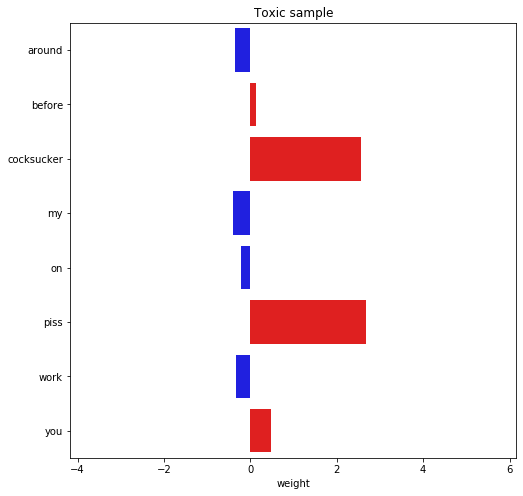

In [57]:
# visualize for easier to interpret
def visualize(title, token_weights, df_weights):
    colors = ['red' if x > 0 else 'blue' for x in token_weights.weight]

    plt.figure(figsize=(8, 8))    
    sns.barplot(data=token_weights, x='weight', y=token_weights.index, palette=colors)
    plt.xlim(df_weights.describe()['weight']['min'], df_weights.describe()['weight']['max'])    
    plt.title(title)
    plt.show()

tokens = [t.lower() for t in train_toxic.iloc[6, -1].split(' ')]
token_weights = df_weights[df_weights.index.isin(tokens)]
visualize('Toxic sample', token_weights, df_weights)

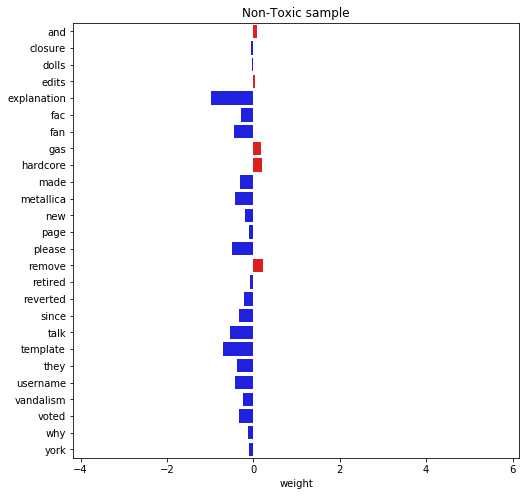

In [58]:
tokens = [t.lower() for t in train_toxic.iloc[0, -1].split(' ')]
token_weights = df_weights[df_weights.index.isin(tokens)]
visualize('Non-Toxic sample', token_weights, df_weights)

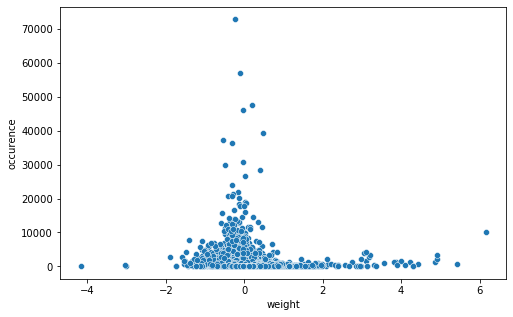

In [59]:
# checking correlation
plt.figure(figsize=(8,5))
sns.scatterplot(data=df_weights, x='weight', y='occurence')
plt.xlabel('weight')
plt.ylabel('occurence')
plt.show()

In [65]:
toxic_words = df_weights[df_weights['weight'] >= 0.2]
toxic_words.sort_values('weight', ascending=False)

,weight,occurence
fuck,6.161359,10144.0
fucker,5.432435,779.0
bitch,4.913691,2266.0
fucking,4.902350,3406.0
asshole,4.869392,1206.0
...,...,...
cuz,0.200111,177.0
madre,0.200110,5.0
triston,0.200092,2.0
camp,0.200084,328.0


In [60]:
# TODO:
# 1. find appropriate weight threshold to determine words is toxic or not
# 2. extract toxic words
# 3. compare extracted words with some toxic wordlist (find references)
# 3.1. https://www.noswearing.com/dictionary
# 3.2. https://www.cs.cmu.edu/~biglou/resources/bad-words.txt

### Finding appropriate threshold

In [61]:
train_compare = train_toxic[['comment_text', 'comment_processed', 'is_toxic']]
train_compare['predicted'] = predict_pipe.predict(train_compare.iloc[:, 0])

# get all predict probabilities
probabilities = predict_pipe.predict_proba(train_compare.iloc[:, 0])

# assign as new columns
train_compare['non_toxic_proba'] = probabilities[:, 0]
train_compare['toxic_proba'] = probabilities[:, 1]

train_compare.head()

,comment_text,comment_processed,is_toxic,predicted,non_toxic_proba,toxic_proba
0,Explanation\nWhy the edits made under my usern...,Explanation Why edits made username Hardcore M...,0,0,0.999395,0.000605
1,D'aww! He matches this background colour I'm s...,D aww He match background colour I seemingly s...,0,0,0.995138,0.004862
2,"Hey man, I'm really not trying to edit war. It...",Hey man I really trying edit war It guy consta...,0,0,0.998044,0.001956
3,"""\nMore\nI can't make any real suggestions on ...",More I make real suggestion improvement I wond...,0,0,0.999945,0.000055
4,"You, sir, are my hero. Any chance you remember...",You sir hero Any chance remember page,0,0,0.924408,0.075592


In [62]:
# drop misclassified observation
train_compare_drop = train_compare.drop(train_compare[train_compare['predicted'] != train_compare['is_toxic']].index)
len(train_compare), len(train_compare_drop)

(159571, 155264)

In [63]:
train_compare_drop[train_compare_drop['is_toxic'] == 0]['toxic_proba'].describe()

count     1.476710e+05
mean      2.175216e-02
std       5.182855e-02
min      4.434108e-273
25%       1.376282e-04
50%       3.558418e-03
75%       1.986666e-02
max       4.999895e-01
Name: toxic_proba, dtype: float64

In [64]:
train_compare_drop[train_compare_drop['is_toxic'] == 1]['toxic_proba'].describe()

count    7593.000000
mean        0.921860
std         0.127421
min         0.500328
25%         0.898648
50%         0.991841
75%         0.999949
max         1.000000
Name: toxic_proba, dtype: float64

## Don't have idea what to do...

In [ ]:
def get_weight(text, title, df_weights):
    tokens = [t.lower() for t in text.split(' ')]
    weights = df_weights[df_weights.index.isin(tokens)]
    visualize(title, weights, df_weights)

In [ ]:
train_middle = train_compare[(train_compare['toxic_proba'] > 0.49) & (train_compare['toxic_proba'] < 0.51)]
train_middle_misclf = train_middle[train_middle['predicted'] != train_middle['is_toxic']]
train_middle_misclf.reset_index(inplace=True)

train_middle_misclf.head()

,index,comment_text,comment_processed,is_toxic,predicted,non_toxic_proba,toxic_proba
0,4609,I'm very upset that you've done this to me and...,I upset done ur big shithead I think ur probbl...,1,0,0.505366,0.494634
1,4684,PISS COMING FROM MY ASSS!,PISS COMING FROM MY ASSS,1,0,0.504977,0.495023
2,5176,"Um... that wasn't me, Jonathan, i was at churc...",Um Jonathan church time IP address accuse,0,1,0.498516,0.501484
3,9350,How pathetic Dencord at you want to go around ...,How pathetic Dencord want go around bullying c...,0,1,0.495313,0.504687
4,11789,Are you moron or stupid or both? I created my ...,Are moron stupid I created personal page move ...,1,0,0.501977,0.498023


Can take reality page Can please take mention reality television page finale Kristin Cavallari proven fake along It soap opera people Nothing see TV real Cavallari tell PEOPLE Fans need understand entertainment Its fun I would never put close friend real relationship show


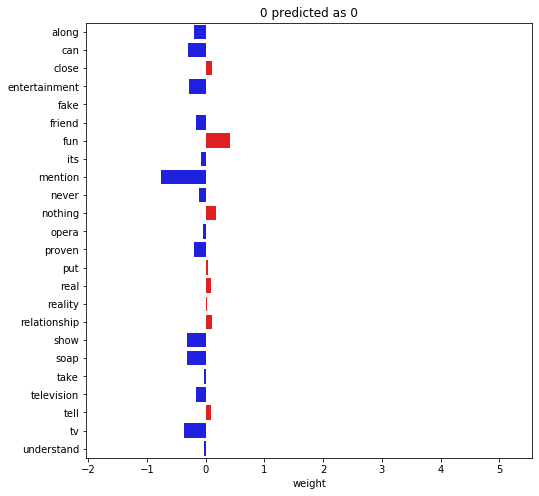

In [ ]:
print(train_middle_misclf.iloc[14, 2])
get_weight(
    train_middle_misclf.iloc[14, 2], 
    f'{train_middle_misclf.iloc[14, 3]} predicted as {train_middle_misclf.iloc[1, 4]}',
    df_weights
)

### Random Guess

In [ ]:
len(df_weights)

4696

In [ ]:
toxic_words = df_weights[df_weights['weight'] > 0.2]
toxic_words.sort_values('weight', ascending=False)

,weight,occurence
fuck,5.566239,10144.0
bitch,4.493247,2266.0
fucking,4.450116,3406.0
asshole,4.373150,1206.0
fucker,4.286746,779.0
...,...,...
stuck,0.201335,339.0
protecting,0.200903,260.0
control,0.200704,1278.0
absolute,0.200167,304.0


In [ ]:
toxic_words.index

Index(['anal', 'arse', 'ass', 'asshole', 'bag', 'ball', 'bastard', 'bitch',
       'bloody', 'blow', 'bullshit', 'bully', 'cock', 'coward', 'crap', 'cunt',
       'damn', 'di', 'dick', 'dirty', 'disgusting', 'douche', 'dumb',
       'dumbass', 'faggot', 'fat', 'fool', 'freak', 'fuck', 'fucked', 'fucker',
       'fuckin', 'fucking', 'hell', 'hole', 'homosexual', 'hypocrite', 'idiot',
       'idiotic', 'ignorant', 'ing', 'jerk', 'kill', 'lazy', 'liar', 'loser',
       'mentally', 'mom', 'motherfucker', 'mouth', 'nerd', 'pathetic', 'penis',
       'piss', 'prick', 'pussy', 'raped', 'retard', 'screw', 'scum', 'shit',
       'shut', 'stupid', 'stupidity', 'suck', 'ugly', 'whore', 'wtf', 'youre'],
      dtype='object')